# Проект "Рынок заведений общественного питания Москвы"

## Описание проекта

В данном проекте мы будем проводить исследование рынка общественного питания в Москве. Инвесторы хотят открыть заведение, но его тип, расположение, меню и цены будут зависеть от результатов данного исследования.

**Цель** — выяснить, какие есть интересные особенности в этой области, чтобы затем предложить место наиболее подходящее инвесторам.

**Задачи:**

1.   Подготовить данные к анализу;
2.   Провести комплексное исследование данных и оценить: какие категории заведений представлены, сколько есть посадочных мест, соотношение сетевых и несетевых заведений, расположение относительно города и др.;
3. На основании данных оценить, насколько реально запустить кофейню в Москве и какие здесь могут быть рекомендации.
4. Сделать выводы относительно рынка общественного питания в Москве.

**Описание данных**

Файл moscow_places.csv:

* name — название заведения;

* address — адрес заведения;

* category — категория заведения, например «кафе», «пиццерия» или «кофейня»;

* hours — информация о днях и часах работы;

* lat — широта географической точки, в которой находится заведение;

* lng — долгота географической точки, в которой находится заведение;

* rating — рейтинг заведения по оценкам пользователей в Яндекс Картах (высшая оценка — 5.0);

* price — категория цен в заведении, например «средние», «ниже среднего», «выше среднего» и так далее;

* avg_bill — строка, которая хранит среднюю стоимость заказа в виде диапазона, например:

  * «Средний счёт: 1000–1500 ₽»;

  * «Цена чашки капучино: 130–220 ₽»;

  * «Цена бокала пива: 400–600 ₽».

  * и так далее;

* middle_avg_bill — число с оценкой среднего чека, которое указано только для значений из столбца avg_bill, начинающихся с подстроки «Средний счёт»:
  
  * Если в строке указан ценовой диапазон из двух значений, в столбец войдёт медиана этих двух значений.

  * Если в строке указано одно число — цена без диапазона, то в столбец войдёт это число.

  * Если значения нет или оно не начинается с подстроки «Средний счёт», то в столбец ничего не войдёт.

* middle_coffee_cup — число с оценкой одной чашки капучино, которое указано только для значений из столбца avg_bill, начинающихся с подстроки «Цена одной чашки капучино»:
  
  * Если в строке указан ценовой диапазон из двух значений, в столбец войдёт медиана этих двух значений.
  * Если в строке указано одно число — цена без диапазона, то в столбец войдёт это число.
  * Если значения нет или оно не начинается с подстроки «Цена одной чашки капучино», то в столбец ничего не войдёт.

* chain — число, выраженное 0 или 1, которое показывает, является ли заведение сетевым (для маленьких сетей могут встречаться ошибки):
  * 0 — заведение не является сетевым
  * 1 — заведение является сетевым

* district — административный район, в котором находится заведение, например
Центральный административный округ;

* seats — количество посадочных мест.

## Предобработка данных

### Получение данных

In [1]:
# импортируем библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import json
import folium
from folium import Marker, Map, Choropleth
from folium import plugins
from folium.plugins import MarkerCluster
from folium.plugins.heat_map import HeatMap

In [2]:
# загружаем данные
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/moscow_places.csv', sep=',')
except:
    df = pd.read_csv('~/Practicum/moscow_places.csv', sep=',')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


In [4]:
df.head()

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,0,NaN
1,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,0,4.0
2,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,0,45.0
3,Dormouse Coffee Shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,0,NaN
4,Иль Марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,1,148.0


Изучите общую информацию о датасете. Сколько заведений представлено? Что можно сказать о каждом столбце? Значения какого типа они хранят?

In [5]:
print('Всего заведений в датасете:', df['name'].nunique())

Всего заведений в датасете: 5614


In [6]:
df['category'].value_counts()

кафе               2378
ресторан           2043
кофейня            1413
бар,паб             765
пиццерия            633
быстрое питание     603
столовая            315
булочная            256
Name: category, dtype: int64

In [7]:
df['name'].value_counts().head(10)

Кафе                189
Шоколадница         120
Домино'с Пицца       76
Додо Пицца           74
One Price Coffee     71
Яндекс Лавка         69
Cofix                65
Prime                50
Хинкальная           44
Шаурма               43
Name: name, dtype: int64

Всего есть данные о 5614 заведениях, большая часть из которых приходится на кафе, рестораны и кофейни. Некоторые организации представлены большим числом точек: например, Кафе, Шоколадница и Домино'с Пицца. Стоит отметить, что здесь название "Кафе" можно спутать с типом заведения.

In [8]:
# столбец с меткой о типе заведения заменяем на более читаемый
df['chain'] = df['chain'].apply(lambda x: 'сетевое заведение' if x == 1 else 'несетевое заведение')

In [9]:
df['chain'].value_counts()

несетевое заведение    5201
сетевое заведение      3205
Name: chain, dtype: int64

Большая часть заведений не является частью какой-либо сети.

### Дубликаты

In [10]:
df['name'] = df['name'].str.lower()
df['address'] = df['address'].str.lower()

In [11]:
print('Количество явных дубликатов в датасете:', df.duplicated().sum())

Количество явных дубликатов в датасете: 0


In [12]:
print('Количество неявных дубликатов (при пересечении) в датасете:', df[['name', 'address']].duplicated().sum())

Количество неявных дубликатов (при пересечении) в датасете: 4


Обнаружились неявные дубликаты! Избавимся от них.

In [13]:
df.drop_duplicates(subset=['name', 'address'], keep=False, inplace=True)

In [14]:
print('Количество неявных дубликатов (при пересечении) в датасете:', df[['name', 'address']].duplicated().sum())

Количество неявных дубликатов (при пересечении) в датасете: 0


### Пропуски значений

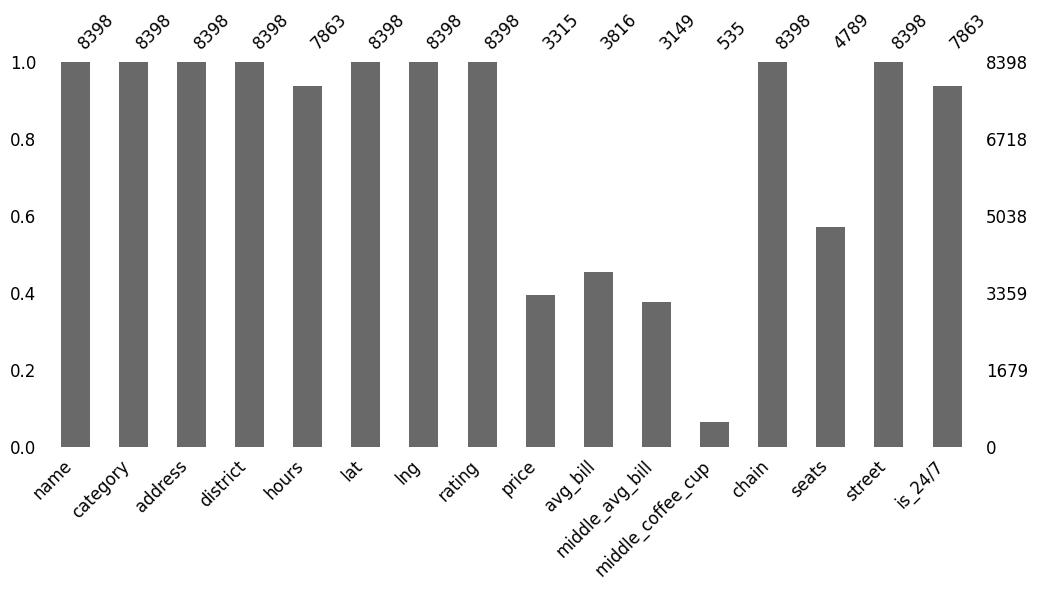

In [72]:
msno.bar(df, figsize = (12, 5), fontsize = 12);

Мы видим большое количество пропущенных значений, но следует приглядеться к их природе. Пропуски в столбцах `middle_coffee_cup` и `middle_avg_bill` зависят от значений столбца `avg_bill`, а значит появились не случайно: это пропуски в тех заведениях, где указан один из измерителей среднего чека ("Средний счет" и "Цена чашки капучино"). В остальных столбцах мы не можем заполнять пропуски в данных, поскольку у нас попросту нет данных. Заполнение наобум или медианными значениями может повлиять на результаты исследования.

### Аномалии

In [16]:
# смотрим разброс значений количественных переменных
df[['rating', 'middle_avg_bill', 'middle_coffee_cup', 'seats']].describe()

,rating,middle_avg_bill,middle_coffee_cup,seats
count,8398.000000,3149.000000,535.000000,4789.000000
mean,4.230138,958.053668,174.721495,108.301107
std,0.470292,1009.732845,88.951103,122.848843
min,1.000000,0.000000,60.000000,0.000000
25%,4.100000,375.000000,124.500000,40.000000
50%,4.300000,750.000000,169.000000,75.000000
75%,4.400000,1250.000000,225.000000,140.000000
max,5.000000,35000.000000,1568.000000,1288.000000


Мы видим, что есть разброс значений в столбцах `middle_avg_bill` и `middle_avg_cup`, но т.к. они берутся из столбца `avg_bill` по медиане, то мы их удалять не будем.

### Добавление столбцов

Создадим столбец street с названиями улиц.

In [17]:
df['street'] = df['address'].str.split(',').str[1]

In [18]:
df.head()

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats,street
0,wowфли,кафе,"москва, улица дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,несетевое заведение,NaN,улица дыбенко
1,четыре комнаты,ресторан,"москва, улица дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,несетевое заведение,4.0,улица дыбенко
2,хазри,кафе,"москва, клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,несетевое заведение,45.0,клязьминская улица
3,dormouse coffee shop,кофейня,"москва, улица маршала федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,несетевое заведение,NaN,улица маршала федоренко
4,иль марко,пиццерия,"москва, правобережная улица, 1б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,сетевое заведение,148.0,правобережная улица


In [19]:
print('Количество пропусков в получившемся столбце:', df['street'].isna().sum())

Количество пропусков в получившемся столбце: 0


Теперь создадим столбец is_24/7 с обозначением, что заведение работает ежедневно и круглосуточно (24/7):

* логическое значение True — если заведение работает ежедневно и круглосуточно;
* логическое значение False — в противоположном случае.

In [20]:
df['is_24/7'] = df['hours'].str.contains('ежедневно, круглосуточно')

In [21]:
df.head()

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats,street,is_24/7
0,wowфли,кафе,"москва, улица дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,несетевое заведение,NaN,улица дыбенко,False
1,четыре комнаты,ресторан,"москва, улица дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,несетевое заведение,4.0,улица дыбенко,False
2,хазри,кафе,"москва, клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,несетевое заведение,45.0,клязьминская улица,False
3,dormouse coffee shop,кофейня,"москва, улица маршала федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,несетевое заведение,NaN,улица маршала федоренко,False
4,иль марко,пиццерия,"москва, правобережная улица, 1б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,сетевое заведение,148.0,правобережная улица,False


In [22]:
print('Общее количество круглосуточных заведений:', df['is_24/7'].value_counts()[1])
print('Что представляет собой', round(df['is_24/7'].value_counts()[1]/df['is_24/7'].count()*100, 2),'% от всех заведений в Москве')

Общее количество круглосуточных заведений: 730
Что представляет собой 9.28 % от всех заведений в Москве


### Выводы по главе

Мы получили и подготовили данные к анализу. Выяснилось следующее:
* В датасете есть данные о 5614 заведениях, большая часть из которых приходится на кафе, рестораны и кофейни.
* Выявлено 4 неявных дубликата, пропусков ещё больше, однако их нельзя устранить: они вызваны структурой данных (взаимоисключающие позиции) и могут повлиять на ход анализа.
* Мы добавили два новых столбца ("улицы" и "круглосуточно"). В Москве только 9% заведений работают 24/7.

## Анализ данных

### Категории заведений

In [23]:
data = df.groupby('category')['name'].count().reset_index()
data.columns = ['category', 'count']
data = data.sort_values('count', ascending=False)
data

,category,count
3,кафе,2375
6,ресторан,2040
4,кофейня,1413
0,"бар,паб",764
5,пиццерия,633
2,быстрое питание,603
7,столовая,315
1,булочная,255


Посмотрим на типы заведений с позиции относительных и абсолютных значений.

In [24]:
fig = go.Figure(data=[go.Pie(labels=data['category'], values=data['count'], pull = [0.1, 0])])
fig.update_layout(title='Круговая диаграмма для типов заведений общественного питания Москвы', # указываем заголовок графика
                  title_font_family='Arial',
                  width=1000, # указываем размеры графика
                  height=650,
                  annotations=[dict(x=1.12, # вручную настраиваем аннотацию легенды
                                    y=1.05,
                                    text='Количество комнат',
                                    showarrow=False)])
fig.show()

In [25]:
fig = px.bar(data,
             x='category',
             y='count',
             text='count',
             title='Категории заведений общественного питания в Москве',
             color='category'
            )
fig.update_layout(xaxis_title='Категории заведений',
                  yaxis_title='Количество заведений',
                  xaxis={'categoryorder':'total descending'})
fig.show()

Построенные графики позволяют сделать следующие выводы: среди заведений общественного питания Москвы кафе уверенно лидируют (2375, 28.3%), затем идут рестораны (2040, 24.3%) и кофейни (1413, 16.8%), а вот последнее место досталось булочным (255, 3%).

### Количество посадочных мест в заведениях по категориям

In [26]:
df.groupby('category')['seats'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
"бар,паб",467.0,124.48,145.16,0.0,48.0,82.0,148.5,1288.0
булочная,147.0,88.12,96.79,0.0,25.0,50.0,120.0,625.0
быстрое питание,349.0,98.89,106.61,0.0,28.0,65.0,140.0,1040.0
кафе,1217.0,97.37,117.92,0.0,35.0,60.0,120.0,1288.0
кофейня,751.0,111.20,127.84,0.0,40.0,80.0,144.0,1288.0
пиццерия,427.0,94.50,112.28,0.0,30.0,55.0,120.0,1288.0
ресторан,1267.0,121.82,123.87,0.0,48.0,86.0,150.0,1288.0
столовая,164.0,99.75,122.95,0.0,40.0,75.5,117.0,1200.0


In [27]:
df.groupby('category')['seats'].median().reset_index().sort_values(by='seats', ascending=False).round(2)

,category,seats
6,ресторан,86.0
0,"бар,паб",82.0
4,кофейня,80.0
7,столовая,75.5
2,быстрое питание,65.0
3,кафе,60.0
5,пиццерия,55.0
1,булочная,50.0


In [28]:
median_seats = df.groupby('category')['seats'].median().reset_index().sort_values(by='seats', ascending=False).round(2)

fig = px.bar(median_seats,
             x='category',
             y='seats',
             text='seats',
             title='Медианное количество мест в заведениях общественного питания Москвы по категориям',
             color='category'
            )
fig.update_layout(xaxis_title='Категории заведений',
                  yaxis_title='Количество заведений',
                  xaxis={'categoryorder':'total descending'})
fig.show()

Из полученных графиков становится ясно:
* Рестораны и бары превосходят остальные заведения по количеству посадочных мест, и это понятно: туда приходят группы людей и им нужно больше времени на визит (приходится увеличивать количество мест, чтобы не терять посетителей), тогда как в булочных, пиццериях и кафе люди едят быстро и не задерживаются (нет смысла иметь много мест)
* Медиана посадочных мест находится в диапазоне от 50 до 86 для всех категорий заведений.

### Соотношение сетевых и несетевых заведений

Рассмотрим соотношение сетевых и несетевых заведений в датасете. Каких заведений больше?

In [29]:
chain = df['chain'].value_counts().reset_index()
chain.columns = ['chain', 'count']
chain

,chain,count
0,несетевое заведение,5196
1,сетевое заведение,3202


In [30]:
fig = go.Figure(data=[go.Pie(labels=chain['chain'], values=chain['count'])])
fig.update_layout(title='Круговая диаграмма соотношения сетевых и несетевых заведений общественного питания Москвы', # указываем заголовок графика
                  title_font_family='Arial',
                  width=1000, # указываем размеры графика
                  height=650,
                  annotations=[dict(x=1.12, # вручную настраиваем аннотацию легенды
                                    y=1.05,
                                    text='Тип заведения',
                                    showarrow=False)])
fig.show()

Нетрудно заметить, что несетевых заведений в датасете больше половины (62%)

### Категории сетевых заведений

Какие категории заведений чаще являются сетевыми?

In [31]:
data_chain = df.groupby(['category', 'chain'])[['name']].count().reset_index()
data_chain = data_chain.rename(columns={'name': 'count'})
data_chain

,category,chain,count
0,"бар,паб",несетевое заведение,596
1,"бар,паб",сетевое заведение,168
2,булочная,несетевое заведение,99
3,булочная,сетевое заведение,156
4,быстрое питание,несетевое заведение,371
5,быстрое питание,сетевое заведение,232
6,кафе,несетевое заведение,1596
7,кафе,сетевое заведение,779
8,кофейня,несетевое заведение,693
9,кофейня,сетевое заведение,720


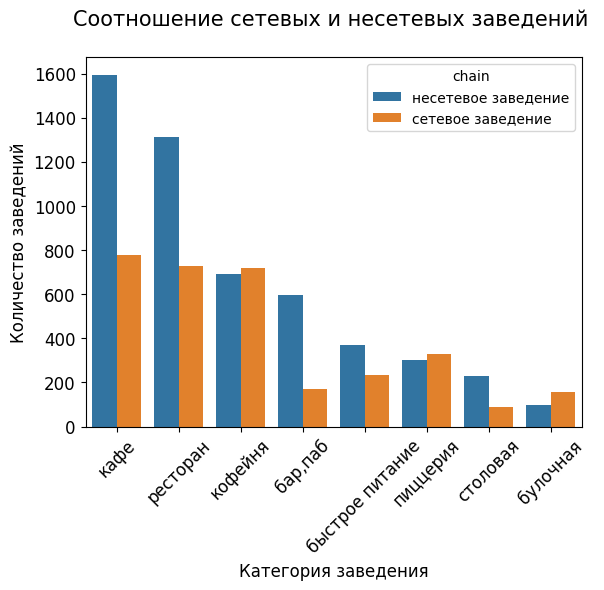

In [32]:
fig = plt.figure()

sns.barplot(x='category', y='count', data=data_chain.sort_values(['count', 'category'], ascending=False), hue='chain')

sns.set_palette("tab10")
plt.xlabel("Категория заведения", fontsize=12)
plt.ylabel("Количество заведений", fontsize=12)
plt.xticks(rotation=45)
plt.title("Соотношение сетевых и несетевых заведений \n", fontsize=15)
plt.tick_params(labelsize=12)

plt.show()

Как мы видим, сетевыми заведениями чаще становятся:
1. Кофейни (отрыв совсем небольшой);
2. Пиццерии (отрыв чуть больше);
3. Булочные.

В остальных категориях несетевые заведения лидируют.

### Топ-15 популярных сетей в Москве

In [33]:
t = df[df['chain'] == 'сетевое заведение']
top_15 = t.groupby('name').agg({'category' : pd.Series.mode, 'district' : 'count'})
top_15 = top_15.rename(columns={'district':'count'})
top_15 = top_15.sort_values('count', ascending = False).reset_index().head(15)
top_15

,name,category,count
0,шоколадница,кофейня,120
1,домино'с пицца,пиццерия,76
2,додо пицца,пиццерия,74
3,one price coffee,кофейня,71
4,яндекс лавка,ресторан,69
5,cofix,кофейня,65
6,prime,ресторан,50
7,хинкальная,кафе,44
8,кофепорт,кофейня,42
9,кулинарная лавка братьев караваевых,кафе,39


In [34]:
print('Количество топ-15 заведений в Москве:', top_15['count'].sum())

Количество топ-15 заведений в Москве: 816


In [35]:
fig = px.bar(top_15,
             x='count',
             y='name',
             text='count',
             title='Топ-15 популярных сетевых заведений общественного питания в Москве',
             color='name'
            )

fig.update_layout(xaxis_title='Количество точек',
                  yaxis_title='Название заведения',
                  xaxis={'categoryorder':'total descending'},
                  width=1000,
                  height=700)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

In [36]:
fig = px.bar(top_15,
             x='count',
             y='category',
             text='name',
             title='Категории сетевых заведений общественного питания в Москве среди топ-15 самых популярных',
             color='name'
            )
fig.update_layout(xaxis_title='Количество заведений',
                  yaxis_title='Категория заведения',
                  yaxis={'categoryorder':'total ascending'},
                  width=900,
                  height=700)
fig.update_traces(textposition='auto')
fig.update_layout(uniformtext_minsize=10, uniformtext_mode='hide')
fig.show()

Жителям и гостям столицы хорошо знакомы многие из перечисленных заведений. На основании полученных графиков мы можем сказать следующее:
* В топ-15 нашего списка попали 816 заведений;
* Шоколадница уверенно лидирует в данном регионе;
* Кофейни на первом месте среди категорий, пиццерии и рестораны делят между собой второе и третье место, а вот булочные в самом конце списка;

### Количество заведений и количество заведений каждой категории по районам

Отобразим общее количество заведений и количество заведений каждой категории по районам.

In [37]:
df_district1 = df.groupby(['district', 'category']).agg({'rating' : 'median', 'name' : 'count'})
df_district1 = df_district1.rename(columns={'name':'count'}).sort_values('rating', ascending = False).reset_index()
df_district1.head()

,district,category,rating,count
0,Центральный административный округ,"бар,паб",4.5,364
1,Западный административный округ,"бар,паб",4.5,50
2,Северо-Западный административный округ,"бар,паб",4.4,23
3,Центральный административный округ,ресторан,4.4,670
4,Центральный административный округ,пиццерия,4.4,113


In [38]:
fig = px.bar(df_district1,
             x='count',
             y='district',
             #text='name',
             title='Распределение заведений общественного питания в Москве по административным округам и категориям',
             color='category'
            )
fig.update_layout(xaxis_title='Количество заведений',
                  yaxis_title='Категория заведения',
                  yaxis={'categoryorder':'total ascending'},
                  width=800,
                  height=700)
fig.update_traces(textposition='auto')
fig.update_layout(uniformtext_minsize=10, uniformtext_mode='hide')
fig.show()

Всего у нас 9 административных округов. На графике мы наблюдаем следующее:
* ЦАО занимает первое место по количеству заведений среди остальных, а СЗАО - последнее;
* Как и ожидалось, в каждом округе лидерами являются рестораны, кафе и кофейни;
* Пропорции различных категорий в целом сохраняются для всех округов. Исключением тут выступают бары, которых заметно больше в центре города (причина тоже понятна).

### Распределение средних рейтингов заведений по категориям

Визуализируем распределение средних рейтингов по категориям заведений. Насколько сильно различаются усреднённые рейтинги в разных типах общепита?

In [39]:
df_category = df.groupby(['category']).agg({'rating' : 'median'}).round(2).sort_values('rating', ascending = False).reset_index()
df_category

,category,rating
0,"бар,паб",4.4
1,булочная,4.3
2,кофейня,4.3
3,пиццерия,4.3
4,ресторан,4.3
5,столовая,4.3
6,быстрое питание,4.2
7,кафе,4.2


In [40]:
fig = px.bar(df_category,
             x='rating',
             y='category',
             text='rating',
             title='Медианный рейтинг сетевых заведений общественного питания в Москве по категориям',
             color='category'
            )
fig.update_layout(xaxis_title='Рейтинг заведения',
                  yaxis_title='Категория заведения',
                  yaxis={'categoryorder':'total ascending'},
                  width=800,
                  height=700)
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=10, uniformtext_mode='show')
fig.update_xaxes(range=[4.1, 4.45])
fig.show()

Итак, здесь мы видим следующее:
* Средний рейтинг для всех категорий заведений не опускается ниже 4 пунктов, что говорит об относительно высоком качестве обслуживания;
* Бары/пабы выступают как заведения с самым высоким рейтингом;
* Пиццерии, рестораны, кофейни, булочные и столовые слегка отстают, их положение примерно одинаковое;
* Быстрое питание и кафе заметно хуже в рейтингах.

### Фоновая картограмма средних рейтингов заведений каждого района

Построим фоновую картограмму (хороплет) со средним рейтингом заведений каждого района.

In [41]:
# читаем файл и сохраняем в переменной
with open('/content/drive/My Drive/Colab Notebooks/admin_level_geomap.geojson', 'r') as f:
    geo_json = json.load(f)

In [42]:
df_rating = df.groupby('district', as_index=False)['rating'].agg('median').round(2).sort_values('rating', ascending=False)
df_rating

,district,rating
5,Центральный административный округ,4.4
0,Восточный административный округ,4.3
1,Западный административный округ,4.3
2,Северный административный округ,4.3
4,Северо-Западный административный округ,4.3
7,Юго-Западный административный округ,4.3
8,Южный административный округ,4.3
3,Северо-Восточный административный округ,4.2
6,Юго-Восточный административный округ,4.2


In [43]:
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

# создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=geo_json,
    data=df_rating,
    columns=['district', 'rating'],
    key_on='feature.name',
    fill_color='YlGn',
    fill_opacity=0.8,
    legend_name='Медианный рейтинг заведений по районам',
).add_to(m)

# выводим карту
m

Хороплет демонстрирует, что именно в ЦАО находятся заведения с самым высоким медианным рейтингом (4.4), а вот СВАО (4.2) и ЮВАО (4.2) слегка отстают.

### Все заведения датасета на тепловой карте

Отобразите все заведения датасета на карте с помощью кластеров средствами библиотеки folium.

In [44]:
m = folium.Map([55.751244, 37.618423], zoom_start=10)

heatmap = df[['lat','lng']]

m.add_child(plugins.HeatMap(heatmap, radius=14))

m

Тепловая показывает, что количество заведений неоднородно: в центре их больше всего, а вот у окраин число снижается (меньше всего на юге и юго-Востоке). Также заметно влияние транспортных артерий и объектов инфраструктуры. Если посмотреть на зеленые зоны, вроде парка Лосиный остров, то там плотность заведений падает до нуля.

### Топ-15 улиц по количеству заведений

Найдем топ-15 улиц по количеству заведений. Построим график распределения количества заведений и их категорий по этим улицам.

In [45]:
#сначала найдем самые популярные улицы
top_15_street_name = df.groupby('street').agg({'street': 'count'})
top_15_street_name = top_15_street_name.rename(columns={'street':'count'})
top_15_street_name = top_15_street_name.sort_values('count', ascending = False).reset_index().head(15)
top_15_street_name

,street,count
0,проспект мира,182
1,профсоюзная улица,122
2,проспект вернадского,108
3,ленинский проспект,107
4,ленинградский проспект,95
5,дмитровское шоссе,88
6,каширское шоссе,77
7,варшавское шоссе,76
8,ленинградское шоссе,70
9,мкад,65


In [46]:
#теперь отберем заведения, которые принадлежат нашему списку с названиями, и сгруппируем по названиям улиц и категориям
top_15_street = df[df['street'].isin(top_15_street_name['street'])]
top_15_street = top_15_street.groupby(['street', 'category'])['name'].count().reset_index()
top_15_street.columns = ['street', 'category', 'count']
top_15_street.sort_values('count', ascending=False)
top_15_street

,street,category,count
0,варшавское шоссе,"бар,паб",6
1,варшавское шоссе,быстрое питание,7
2,варшавское шоссе,кафе,18
3,варшавское шоссе,кофейня,14
4,варшавское шоссе,пиццерия,4
...,...,...,...
106,улица миклухо-маклая,быстрое питание,4
107,улица миклухо-маклая,кафе,21
108,улица миклухо-маклая,кофейня,4
109,улица миклухо-маклая,пиццерия,2


In [47]:
print('Всего заведений, которые расположены на топ-15 самых популярных с точки зрения общепита улиц в Москве:', top_15_street['count'].sum())

Всего заведений, которые расположены на топ-15 самых популярных с точки зрения общепита улиц в Москве: 1256


In [48]:
fig = px.bar(top_15_street,
             x='count',
             y='street',
             text='category',
             title='Топ-15 улиц по количеству заведений',
             color='category'
            )
fig.update_layout(xaxis_title='Количество заведений',
                  yaxis_title='Название улицы',
                  yaxis={'categoryorder':'total ascending'},
                  width=900,
                  height=800)
fig.update_traces(textposition='auto')
fig.update_layout(uniformtext_minsize=10, uniformtext_mode='hide')
fig.show()

Из получившегося графика становится понятно:
* Проспект Мира лидирует по количеству заведений. Это связано с тем, что улица очень длинная (9км) и там чисто географически больше пространства. Это также крупная магистральная улица, которая соединяет центр и север столицы. На ней расположены 5 станций метро (где метро, там и большие потоки людей).
* Кафе, рестораны и кофейни в целом хорошо представлены на всех улицах;
* Есть особая улица (МКАД), где кафе значительно больше, чем других типов заведений: очевидно, это связано с расположением улицы и потребностями автомобилистов.

Таким образом, количество заведений на улице главным образом определяют: *инфраструктура* (чем ближе к транспортной артерии, тем больше заведений), *длина улицы* и *местоположение относительно центра* (в центре всегда больше заведений, чем на окраине). Некоторые факторы (наличие культурных объектов и т.п.) мы здесь не учитываем.

### Улицы, где есть только один объект общепита

Найдем улицы, на которых находится только один объект общепита. Что можно сказать об этих заведениях?

In [49]:
#ищем названия подходящих под условие улиц
one_canteen_streets = df['street'].value_counts().reset_index()
one_canteen_streets.columns = ['street', 'count']
one_canteen_streets = one_canteen_streets[one_canteen_streets['count'] == 1]
one_canteen_streets

,street,count
989,улица стасовой,1
990,малая тульская улица,1
991,улица губкина,1
992,черёмушкинский проезд,1
993,андреевский пешеходный мост,1
...,...,...
1442,малый казённый переулок,1
1443,улица маршала соколовского,1
1444,улица максимова,1
1445,басманный тупик,1


In [50]:
#фильтруем наш датасет по найденным улицам и группируем по категориям
df[df['street'].isin(one_canteen_streets['street'])].value_counts('category').reset_index().rename(columns={0: 'count'})

,category,count
0,кафе,159
1,ресторан,94
2,кофейня,84
3,"бар,паб",39
4,столовая,36
5,быстрое питание,23
6,пиццерия,15
7,булочная,8


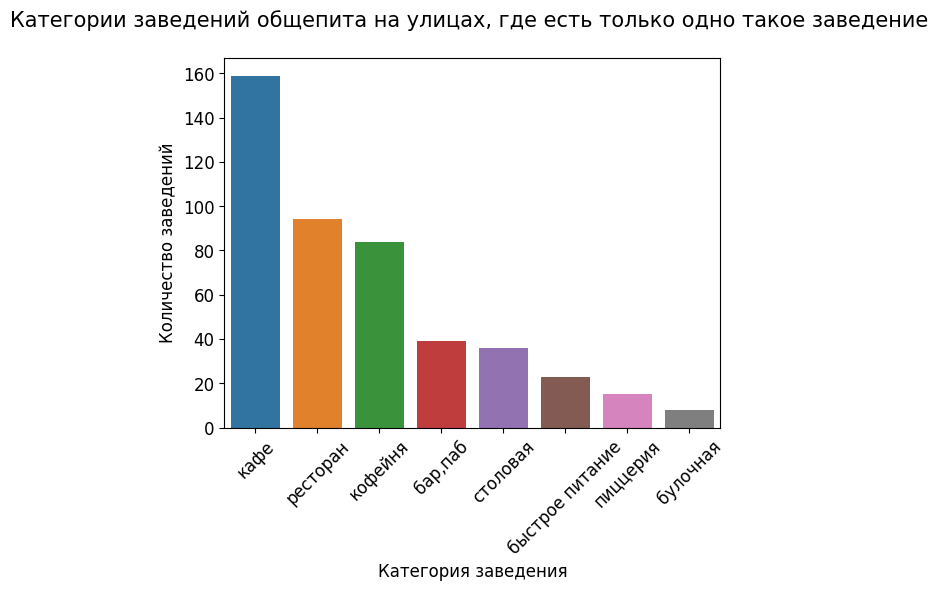

In [66]:
fig = plt.figure()

sns.barplot(x='category', y='count', data=df[df['street'].isin(one_canteen_streets['street'])].value_counts('category').reset_index().rename(columns={0: 'count'}))

sns.set_palette("tab10")
plt.xlabel("Категория заведения", fontsize=12)
plt.ylabel("Количество заведений", fontsize=12)
plt.xticks(rotation=45)
plt.title("Категории заведений общепита на улицах, где есть только одно такое заведение \n", fontsize=15)
plt.tick_params(labelsize=12)

plt.show()

На графике мы видим, что на улицах, где нет других заведений общепита, чаще всего можно встретить кафе, чуть реже ресторан или кофейню. Булочные встречаются реже всего.

Вероятно, полученные результаты можно объяснить тем, что кафе являются наиболее типичными заведениями в городе и поэтому они появляются в первую очередь. Не очень высокие цены, плюс умеренные стандарты обслуживания. Столовых, ресторанов быстрого питания и пиццерий меньше, потому что в целом улица не воспринимается как "улица с общепитом", на ней слишком мало людей для таких заведений.

### Средний чек в заведениях

Значения средних чеков заведений хранятся в столбце middle_avg_bill. Эти числа показывают примерную стоимость заказа в рублях, которая чаще всего выражена диапазоном. Посчитаем медиану столбца middle_avg_bill для каждого района.

In [52]:
median_bill = df.groupby('district', as_index=False)['middle_avg_bill'].agg('median').sort_values('middle_avg_bill', ascending = False)
median_bill

,district,middle_avg_bill
1,Западный административный округ,1000.0
5,Центральный административный округ,1000.0
4,Северо-Западный административный округ,700.0
2,Северный административный округ,650.0
7,Юго-Западный административный округ,600.0
0,Восточный административный округ,575.0
3,Северо-Восточный административный округ,500.0
8,Южный административный округ,500.0
6,Юго-Восточный административный округ,450.0


In [53]:
print('Средний чек по городу составляет', df['middle_avg_bill'].median(), 'рублей')

Средний чек по городу составляет 750.0 рублей


Используем это значение в качестве ценового индикатора района. Построим тепловую карту с полученными значениями. Как удалённость от центра влияет на цены в заведениях?

In [54]:
m = folium.Map([55.751244, 37.618423], zoom_start=10)

heatmap_data = df[['lat','lng', 'middle_avg_bill']].copy().dropna() # без удаления пустых значений heatmap не сработает
heatmap = heatmap_data[['lat','lng', 'middle_avg_bill']]

HeatMap(data=heatmap, radius=14).add_to(m)

m

Фоновая картограмма с ценовыми индикаторами районов демонстрирует следующее:
* Виден тренд на уменьшение чека при движении от центра города;
* Медианный чек максимален в центре (в пределах ТТК) и на юго-западе Москвы (вдоль Ленинского проспекта, Профсоюзной улицы);
* Даже вне этих локаций чек сохраняет высокие значения в торговых центрах и скоплениях заведений (рядом с университетами, к примеру)

### Общий вывод

Мы проделали многоаспектный анализ рынка заведений общественного питания Москвы и можем сделать следующие выводы:
* Cреди заведений общественного питания Москвы кафе представлены лучше всего, затем идут рестораны и кофейни, а вот последнее место досталось булочным.
* Рестораны и бары превосходят остальные заведения по количеству посадочных мест. Медиана посадочных мест находится в диапазоне от 50 до 80.
* Доле несетевых заведений в датасете составляет 62%. Сетевыми заведениями чаще становятся кофейни, пиццерии и булочные. В остальных категориях несетевые заведения превалируют.
* В топ-15 заведений Москвы попали 816 объектов. По количеству точек Шоколадница уверенно лидирует. Если смотреть на категории, то кофейни на первом месте, пиццерии и рестораны делят между собой второе и третье место, а вот булочные в самом конце списка. В топ-5 попали попали сразу 2 пиццерии (Домино'с и Додо заметно опережают конкурентов)
* Центральный округ занимает первое место по количеству заведений среди остальных, а Северо-Западный - последнее. В каждом округе большего всего ресторанов, кафе и кофеен. Интересная закономерность в количестве баров: их заметно больше в центре города (в центре это является одним из популярных вариантов досуга и статусного потребления).
* Бары/пабы выступают как заведения с самым высоким рейтингом. Пиццерии, рестораны, кофейни, булочные и столовые слегка отстают, их положение примерно одинаковое. Быстрое питание и кафе заметно хуже в рейтингах. В целом рейтинг не опускается ниже 4 из 5.
* В Центральном округе находятся заведения с самым высоким средним рейтингом (4.4), вот Северо-Восточный и Юго-Восточный округа слегка отстают (4.2).
* Карта с кластерами показывает, что количество заведений неоднородно: в центре их больше всего, а вот у окраин число снижается (меньше всего на юге и юго-востоке).
* Если смотреть на улицы, то Проспект Мира лидирует по количеству заведений. Кафе, рестораны и кофейни в целом хорошо представлены на всех улицах. Есть особая улица (МКАД), где кафе значительно больше, чем других типов заведений: очевидно, это связано с локацией и потребностями автомобилистов.
* На улицах, где нет других заведений общепита, чаще всего можно встретить кафе, чуть реже ресторан или кофейню. Булочные встречаются реже всего.
* Есть тренд на уменьшение среднего чека при движении от центра города. Однако даже вне чек сохраняет высокие значения в торговых центрах и скоплениях заведений (рядом с университетами, к примеру)

## Детализируем исследование: открытие кофейни

Основателям фонда «Shut Up and Take My Money» не даёт покоя успех сериала «Друзья». Их мечта — открыть такую же крутую и доступную, как «Central Perk», кофейню в Москве. Будем считать, что заказчики не боятся конкуренции в этой сфере, ведь кофеен в больших городах уже достаточно. Попробуем определить, осуществима ли мечта клиентов.

### Число конкурентов и распределение по городу

Для решения нашей задачи нам потребуется ответить на несколько вопросов. Начнем с вопроса о количестве конкурентов и их распределении по городу.

In [55]:
coffee_house = df[df['category'] == 'кофейня']
print('Объектов категории "кофейня" в нашей выборке:', coffee_house['name'].count().sum())

Объектов категории "кофейня" в нашей выборке: 1413


In [56]:
#группируем данные о кофейнях по районам города
coffee_house_districts = coffee_house.groupby('district').agg({'district':'count'}).rename(columns={'district':'count'}).sort_values('count', ascending=False).reset_index()
coffee_house_districts

,district,count
0,Центральный административный округ,428
1,Северный административный округ,193
2,Северо-Восточный административный округ,159
3,Западный административный округ,150
4,Южный административный округ,131
5,Восточный административный округ,105
6,Юго-Западный административный округ,96
7,Юго-Восточный административный округ,89
8,Северо-Западный административный округ,62


In [57]:
fig = px.bar(coffee_house_districts,
             x='count',
             y='district',
             text='count',
             title='Столбчатый график распределения кофеен по округам Москвы',
             color='district'
            )
fig.update_layout(xaxis_title='Количество кофеен',
                  yaxis_title='Название региона',
                  xaxis={'categoryorder':'total descending'})
fig.show()

**Вывод:** Всего у нас 1413 конкурентов, которые расположены главным образом в центре города, а вот на Юго-Западе, Юго-Востоке и Северо-Западе их количество резко падает.

### Круглосуточные кофейни

Стоит определить, есть ли круглосуточные кофейни.

In [58]:
coffee_house_24_7 = coffee_house[coffee_house['is_24/7'] == 1]

print('Всего в городе есть', coffee_house_24_7['name'].count(), 'кругосуточных кофеен.')
print('Это составляет', round(coffee_house_24_7['name'].count()/coffee_house['name'].count()*100, 2), '% от их общего количества.')

Всего в городе есть 59 кругосуточных кофеен.
Это составляет 4.18 % от их общего количества.


In [59]:
coffee_house_districts_24_7 = coffee_house_24_7.groupby('district').agg({'district':'count'}).rename(columns={'district':'count'}).sort_values('count', ascending=False).reset_index()
coffee_house_districts_24_7

,district,count
0,Центральный административный округ,26
1,Западный административный округ,9
2,Юго-Западный административный округ,7
3,Восточный административный округ,5
4,Северный административный округ,5
5,Северо-Восточный административный округ,3
6,Северо-Западный административный округ,2
7,Юго-Восточный административный округ,1
8,Южный административный округ,1


In [60]:
fig = px.bar(coffee_house_districts_24_7,
             x='count',
             y='district',
             text='count',
             title='Столбчатый график распределения круглосуточных кофеен по округам Москвы',
             color='district'
            )
fig.update_layout(xaxis_title='Количество кофеен',
                  yaxis_title='Название региона',
                  xaxis={'categoryorder':'total descending'})
fig.show()

**Вывод:** Круглосуточных кофеен в городе относительно мало (меньше 5% от общего числа) и их подавляющее большинство расположено в центре города.

### Рейтинги кофеен

Определим, какие у кофеен рейтинги и как они распределяются по районам.

In [61]:
coffee_house_rating = coffee_house.groupby(['district'], \
                        as_index = False)[['rating']].median().sort_values('rating', ascending=False)
coffee_house_rating

,district,rating
0,Восточный административный округ,4.3
2,Северный административный округ,4.3
3,Северо-Восточный административный округ,4.3
4,Северо-Западный административный округ,4.3
5,Центральный административный округ,4.3
6,Юго-Восточный административный округ,4.3
7,Юго-Западный административный округ,4.3
8,Южный административный округ,4.3
1,Западный административный округ,4.2


In [62]:
fig = px.bar(coffee_house_rating,
             x='rating',
             y='district',
             text='rating',
             title='Столбчатый график распределения рейтингов кофеен по округам Москвы',
             color='district'
            )
fig.update_layout(xaxis_title='Количество кофеен',
                  yaxis_title='Название региона',
                  xaxis={'categoryorder':'total descending'})
fig.update_xaxes(range=[4.1, 4.4])
fig.show()

**Вывод:** Рейтинги кофеен по всему городу примерно одинаковые, если не считать Западный округ, который слегка отстает.

### Стоимость чашки капучино

Выясним, на какую стоимость чашки капучино стоит ориентироваться при открытии новой кофейни.

In [63]:
coffee_house_cup_price = coffee_house.groupby(['district'], \
                        as_index = False)[['middle_coffee_cup']].median().sort_values('middle_coffee_cup', ascending=False)
coffee_house_cup_price

,district,middle_coffee_cup
7,Юго-Западный административный округ,198.0
5,Центральный административный округ,190.0
1,Западный административный округ,189.0
4,Северо-Западный административный округ,165.0
3,Северо-Восточный административный округ,162.5
2,Северный административный округ,159.0
8,Южный административный округ,150.0
6,Юго-Восточный административный округ,147.5
0,Восточный административный округ,135.0


In [64]:
print('Медианная цена на чашку капучино по городу равна:', round(coffee_house_cup_price['middle_coffee_cup'].median()), 'рублей')

Медианная цена на чашку капучино по городу равна: 162 рублей


In [65]:
fig = px.bar(coffee_house_cup_price,
             x='middle_coffee_cup',
             y='district',
             text='middle_coffee_cup',
             title='Столбчатый график распределения рейтингов кофеен по округам Москвы',
             color='district'
            )
fig.update_layout(xaxis_title='Количество кофеен',
                  yaxis_title='Название региона',
                  xaxis={'categoryorder':'total descending'})
fig.update_xaxes(range=[130, 200])
fig.show()

**Вывод:** Медианная цена на чашку капучино составляет 162 рубля. Удивительно, но потолок цен мы встречаем не в центре, а на юго-западе (там чашка стоит аж 198 рублей). Самое же дешевое кофе в восточном округе, где оно в среднем обойдется в 135 рублей.

### Рекомендации для открытия кофейни

Итак, на основании полученных данных можно сделать следующие рекомендации для открытия новой кофейни:
* **Юго-Западный округ** выглядит как привлекательная локация (относительно мало конкурентов, высокая цена за чашку);
* Можно создать **круглосуточное заведение**, потому что в этой части города на них есть спрос (в этой части города проживает большое количество студентов, которым иногда нужно найти ночное пристанище), но придется соперничать с Шоколадницей;
* **Рейтинг кофеен** в этом округе не отличается от медианного по городу;
* **Цену на чашку** капучино резонно установить на уровне 175 рублей, что на ~10 рубля больше, чем в среднем по городу, но на 15-20 рублей ниже, чем в этом же районе (так можно завоевать интерес новых покупателей);

## Презентация проекта с выводами

[Презентация проекта](https://drive.google.com/file/d/1z5hJexr_f25PWCYyCn_WCXZnYUJ_KV1C/view?usp=share_link)